In [1]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

In [2]:
from typing import List, Tuple

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch.nn.functional as F

In [4]:
import pandas as pd

In [5]:
from tqdm import tqdm

In [6]:
model_name = "Qwen/Qwen2.5-1.5B"

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Study of token's space shift invarience on deterministic sequences 

In [8]:
def generate_pattern_sequence(pattern: list, seq_len: int, pattern_padding: int = 0) -> np.ndarray:
    not_full_seq = pattern * int(seq_len / len(pattern))
    pattern_seq = np.array(pattern * pattern_padding + not_full_seq + pattern[:seq_len - len(not_full_seq)], dtype=int)
    return pattern_seq

In [9]:
def run_sequence_through_model(model, sequence) -> Tuple[Tensor, Tensor]:
    with torch.no_grad():
            outputs = model(sequence)
            logits = outputs.logits
            
    shifted_logits = logits[:, :-1, :].contiguous().squeeze(0)        
    predicts = torch.argmax(shifted_logits, dim=1).squeeze()
    return predicts, shifted_logits   

In [10]:
def test_sequence_shift(model, sequence: np.ndarray, shifts: list, test_seq_len: int) -> List[Tuple[float, float]]:
    test_seq_len = len(sequence) - 1 if test_seq_len >= len(sequence) else test_seq_len
    results = []
    for shift in tqdm(shifts):
        inputs_ids = torch.tensor(sequence + shift, dtype=torch.int32).unsqueeze(0)
        predicts, shifted_logits = run_sequence_through_model(model, inputs_ids)
        test_seq = inputs_ids[:, -test_seq_len:].contiguous().squeeze(0)
        shifted_inputs = inputs_ids[:, 1:].contiguous().squeeze(0)
        
        actual_log_probs = F.log_softmax(shifted_logits, dim=-1)[torch.arange(shifted_inputs.shape[0]), shifted_inputs]
        mean_log_likelyhood = actual_log_probs.mean().numpy()
        acc = (predicts[-test_seq_len:] == test_seq).sum().numpy() / test_seq_len
        median_dist = torch.median(predicts[-test_seq_len:] - test_seq).numpy()
        
        for matching_start in range(shifted_inputs.shape[0]):
            if (predicts[matching_start:] == shifted_inputs[matching_start:]).all():
                break
        
        results.append((acc, mean_log_likelyhood, median_dist, matching_start))
            
    return results

In [12]:
def plot_shift_test_results(results, shift_range, plot_name, subplot_titles):
    fig = make_subplots(rows=len(subplot_titles), cols=1, subplot_titles=subplot_titles)
    for i in range(len(subplot_titles)):
        fig.add_trace(go.Scatter(x=shift_range, y=np.array([r[i] for r in results]), mode='lines'), row=i+1, col=1)
    # Update layout
    fig.update_layout(title_text=plot_name, height=1000, width=1800, title_font=dict(size=24), margin=dict(t=50, b=50, l=50, r=50))
    fig.update_xaxes(title_text='Index Shift', row=1, col=1)
    fig.update_xaxes(title_text='Index Shift', row=2, col=1)
    fig.update_xaxes(title_text='Index Shift', row=3, col=1)
    fig.update_xaxes(title_text='Index Shift', row=4, col=1)
    fig.update_yaxes(title_text='Accuracy', row=1, col=1)
    fig.update_yaxes(title_text='Log-Likelyhood', row=2, col=1)
    fig.update_yaxes(title_text='Median Error', row=3, col=1)
    fig.update_yaxes(title_text='Start of matching', row=4, col=1)
    # Show the figure
    fig.show()

In [116]:
def plot_sequence_prediction(factual_seq, predicted_seq, start_from_idx, plot_name, height, width):
    fig = go.Figure()
    x = np.arange(start_from_idx + 2, len(factual_seq) + 1)
    fig.add_trace(go.Scatter(x=x, y=factual_seq[start_from_idx:], mode='markers', marker=dict(size=13), name="Factual Sequience"))
    fig.add_trace(go.Scatter(x=x, y=predicted_seq[start_from_idx:], mode='markers', name="Predicted Sequience"))
    fig.update_layout(title_text=plot_name, height=height, width=width, title_font=dict(size=24), margin=dict(t=50, b=50, l=50, r=50))
    fig.update_xaxes(title_text="Element's Index", range=[1, len(factual_seq)])
    fig.update_yaxes(title_text="Token's Index")
    fig.show()

In [115]:
def plot_log_prob(logits, factual_seq, plot_name, height=400, width=1200):
    fig = go.Figure()
    x = np.arange(2, logits.shape[0] + 1)
    log_probs = F.log_softmax(logits, dim=-1)
    actual_log_probs = log_probs[torch.arange(logits.shape[0]), factual_seq[1:]].numpy()
    predicted_log_probs = log_probs.numpy().max(axis=1)
    fig.add_trace(go.Scatter(x=x, y=predicted_log_probs, mode='lines', line={'width': 6}, name="Log-Probability of predicted token"))
    fig.add_trace(go.Scatter(x=x, y=actual_log_probs, mode='lines', line={'width': 3}, name="Log-Probability of factual token"))
    fig.update_layout(title_text=plot_name, title_font=dict(size=24), height=height, width=width, margin=dict(t=50, b=50, l=50, r=50))
    fig.update_xaxes(title_text="Element's Index", range=[1, len(factual_seq)])
    fig.update_yaxes(title_text="Log-Probability")
    fig.show()

### Repeated token

In [93]:
rep_seq = generate_pattern_sequence([0], 256, 2)
rep_predicts, rep_logits = run_sequence_through_model(model, torch.tensor(rep_seq, dtype=torch.int32).unsqueeze(0))

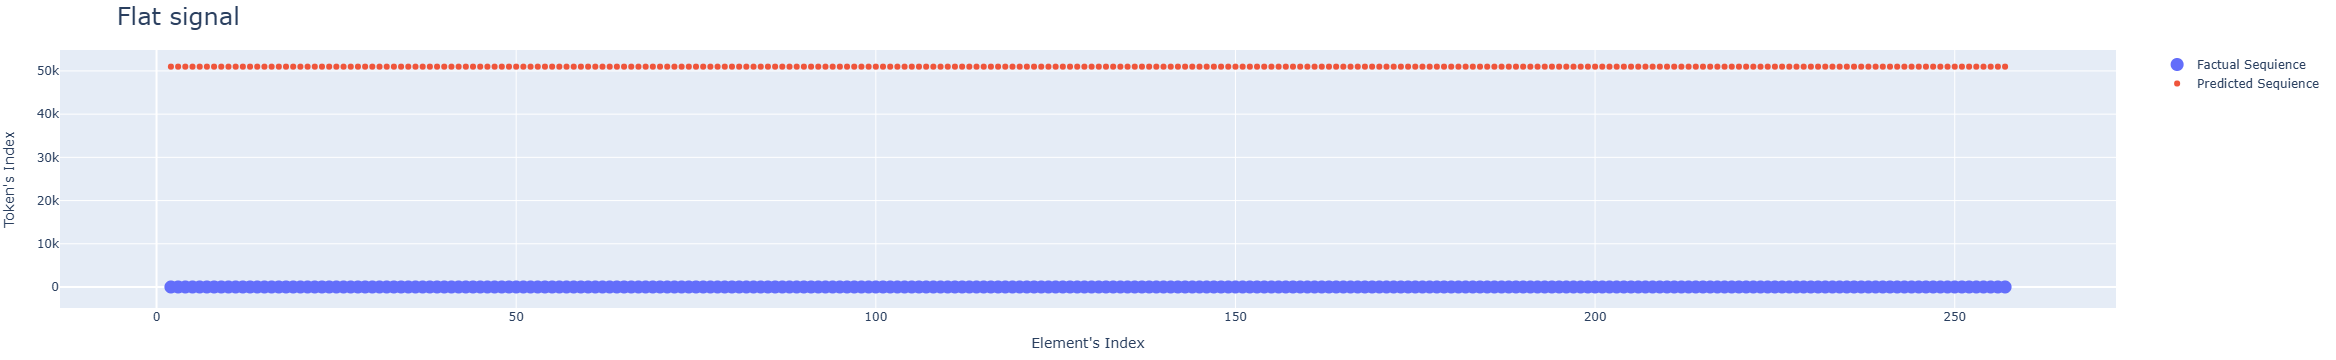

In [94]:
plot_sequence_prediction(factual_seq=rep_seq[1:], predicted_seq=rep_predicts.numpy(), start_from_idx=0, plot_name="Flat signal", height=300, width=1000)

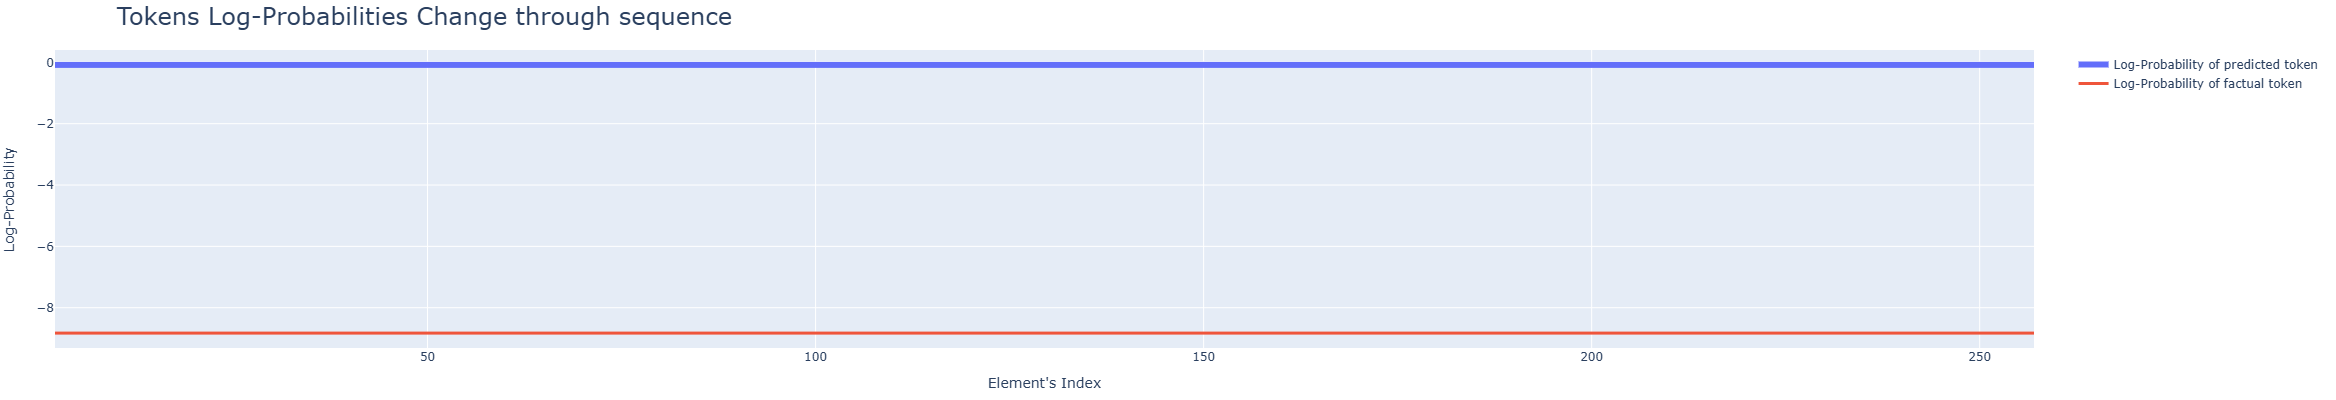

In [95]:
plot_log_prob(logits=rep_logits, factual_seq=rep_seq, plot_name="Tokens Log-Probabilities Change through sequence")

In [13]:
repeated_token_seq = generate_pattern_sequence([0], 256, 2)
result = test_sequence_shift(model, sequence=repeated_token_seq, shifts=range(0, 100_000, 200), test_seq_len=256)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [56:22<00:00,  6.77s/it]


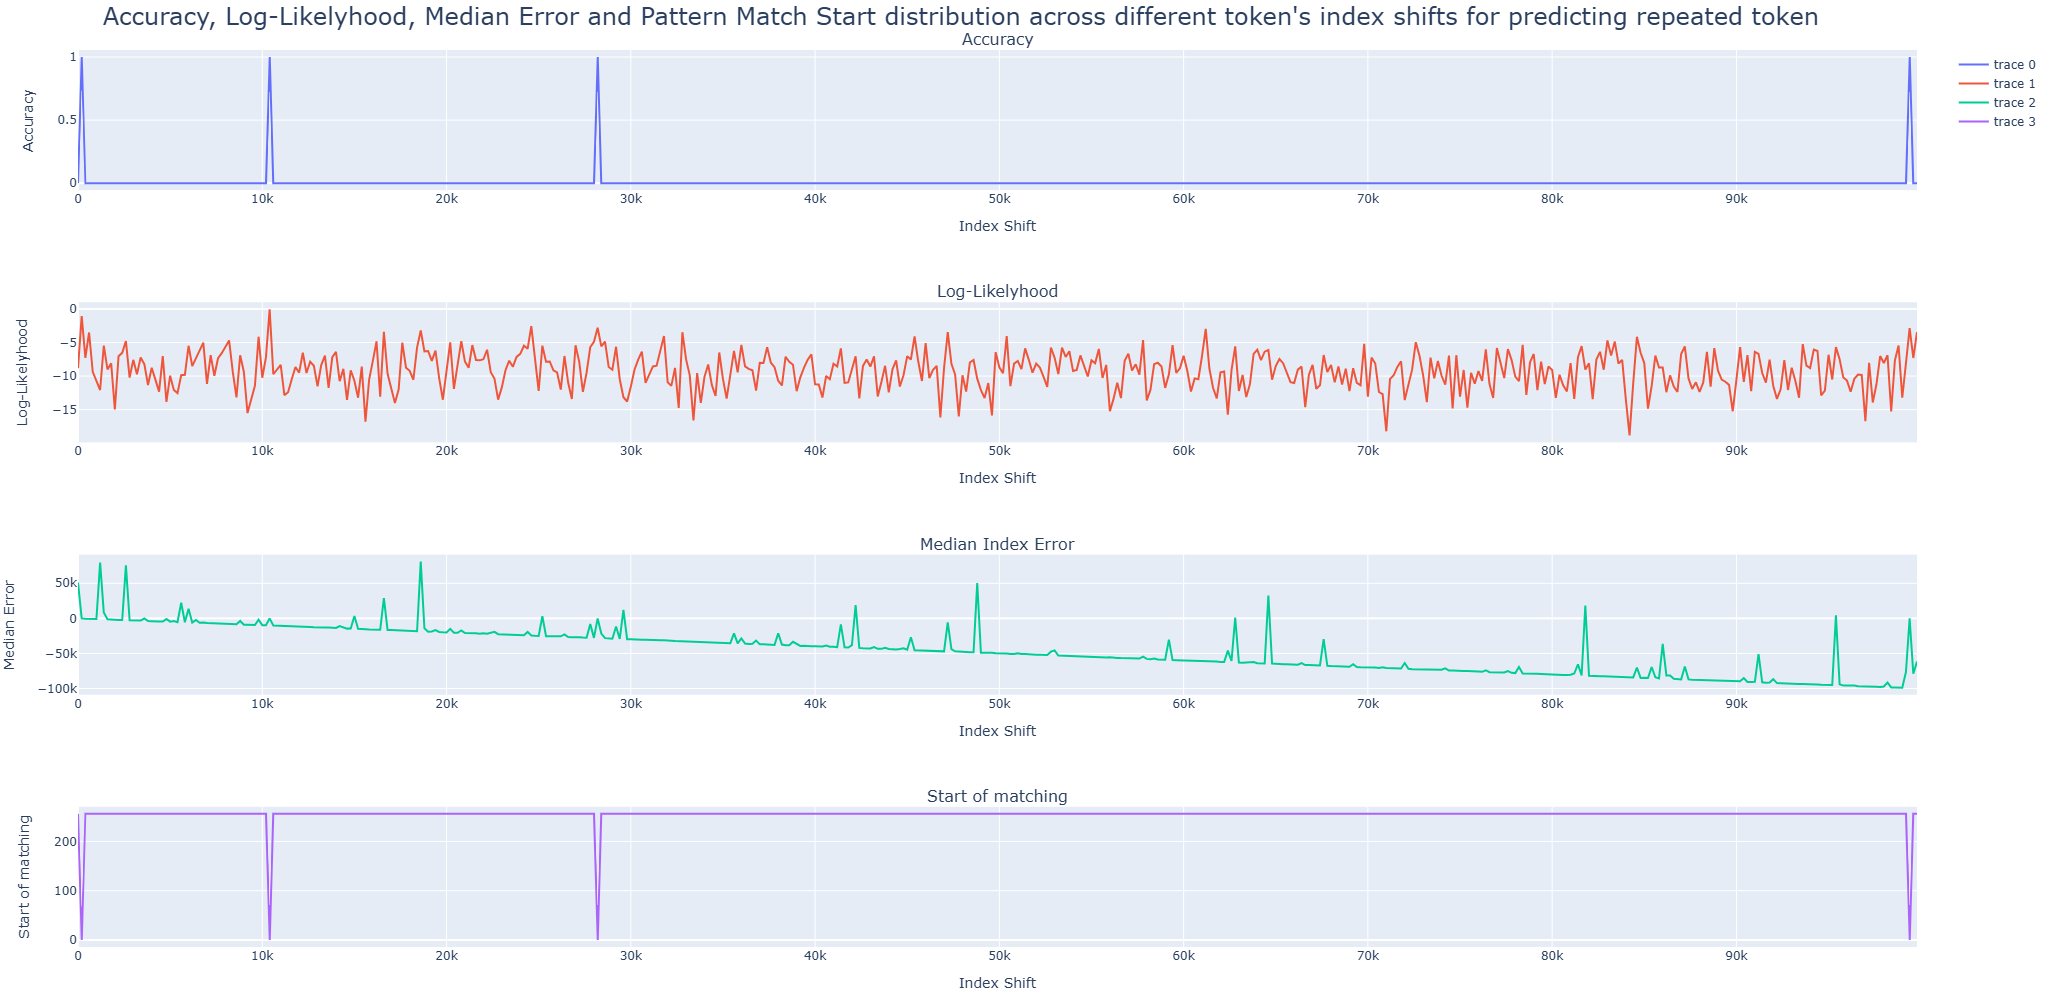

In [14]:
plot_shift_test_results(results=result, shift_range=np.array(range(0, 100_000, 200)), plot_name="Accuracy, Log-Likelyhood, Median Error and Pattern Match Start distribution across different token's index shifts for predicting repeated token",
                        subplot_titles=['Accuracy', 'Log-Likelyhood', 'Median Index Error', 'Start of matching'])

In [15]:
tokenizer.convert_ids_to_tokens([0, 200, 10400, 28200, 99400])

['!', 'Č', 'zz', 'Âº', 'å¯Ł']

### Sequence of alterating tokens

In [29]:
alter_tokens_seq = generate_pattern_sequence([0, 1], 256, 1)
result_alteration = test_sequence_shift(model, sequence=alter_tokens_seq, shifts=range(0, 100_000, 200), test_seq_len=256)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [49:20<00:00,  5.92s/it]


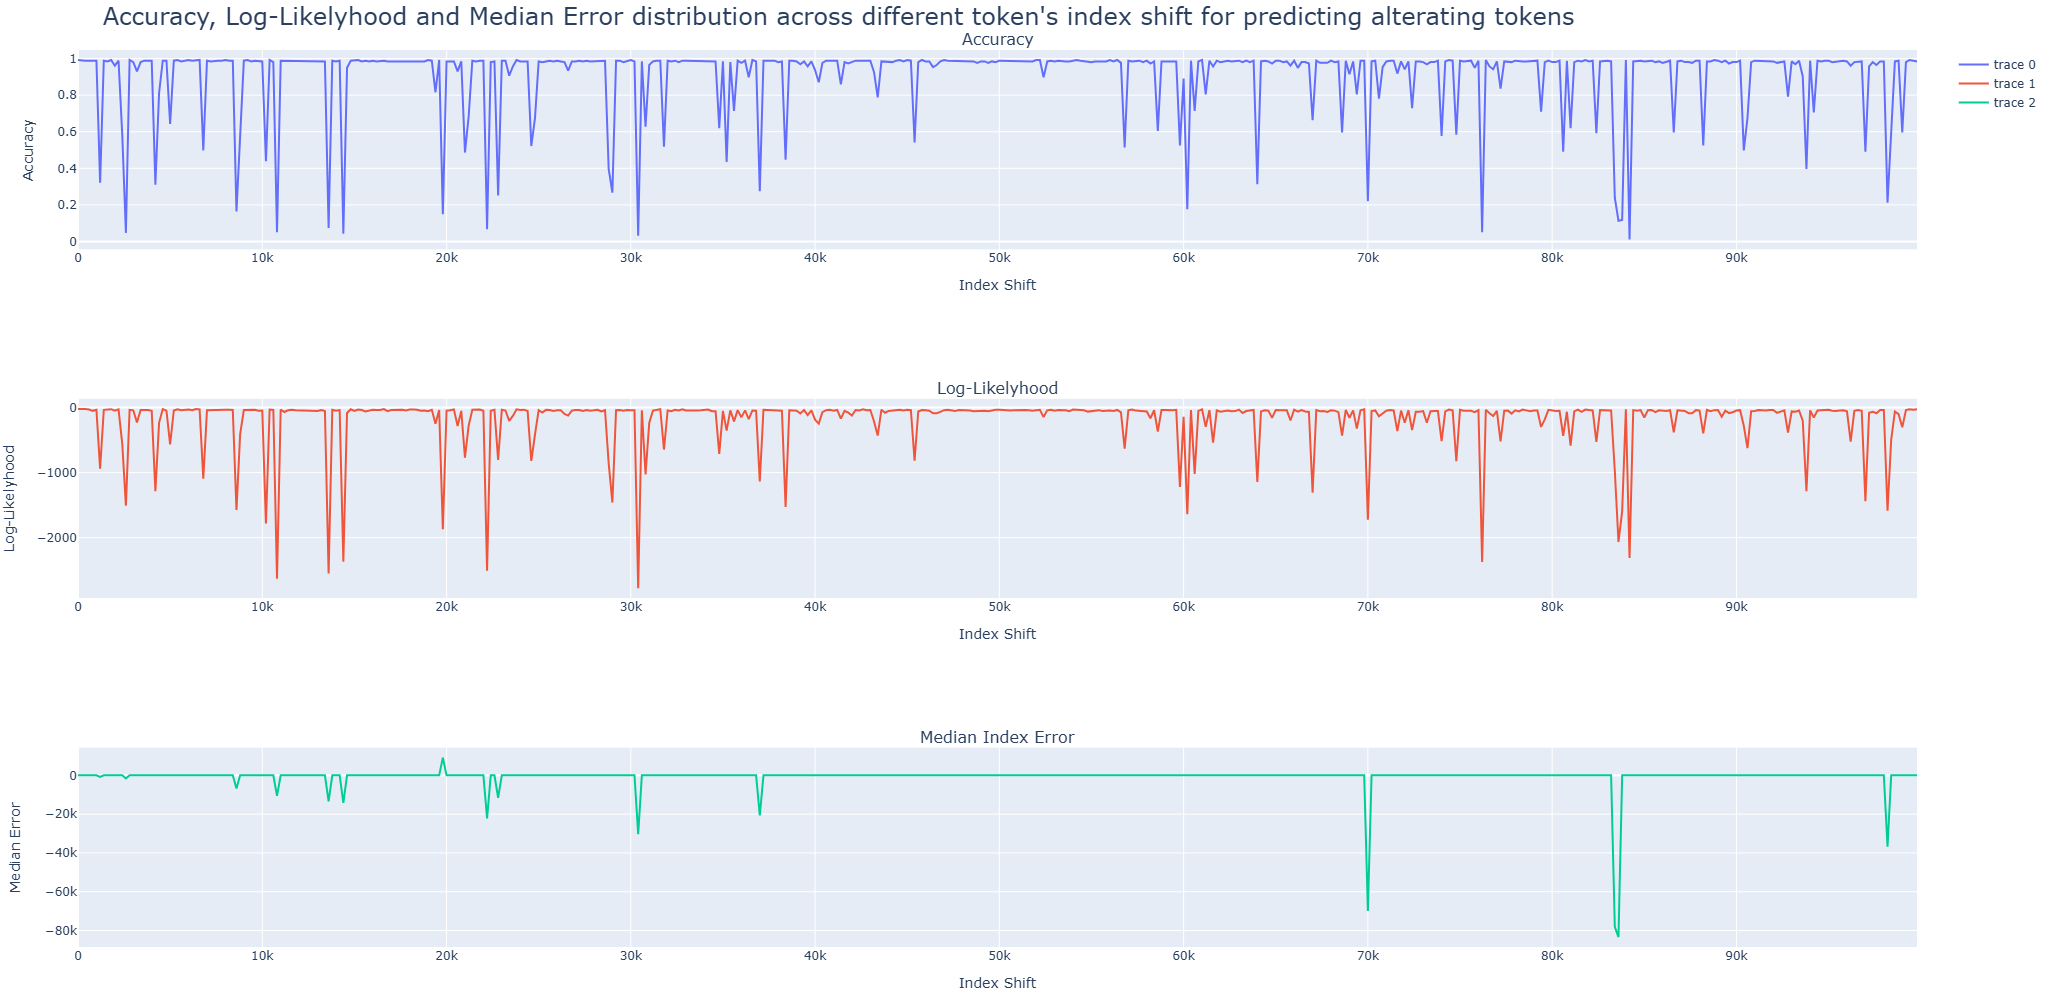

In [59]:
fig = make_subplots(rows=3, cols=1, subplot_titles=['Accuracy', 'Log-Likelyhood', 'Median Index Error'])

fig.add_trace(go.Scatter(x=np.array(range(0, 100_000, 200)), y=np.array([r[0] for r in result_alteration]), mode='lines'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.array(range(0, 100_000, 200)), y=np.array([r[1] for r in result_alteration]), mode='lines'), row=2, col=1)
fig.add_trace(go.Scatter(x=np.array(range(0, 100_000, 200)), y=np.array([r[2] for r in result_alteration]), mode='lines'), row=3, col=1)

# Update layout
fig.update_layout(title_text="Accuracy, Log-Likelyhood and Median Error distribution across different token's index shift for predicting alterating tokens", height=1000, width=1800, title_font=dict(size=24), margin=dict(t=50, b=50, l=50, r=50))
fig.update_xaxes(title_text='Index Shift', row=1, col=1)
fig.update_xaxes(title_text='Index Shift', row=2, col=1)
fig.update_xaxes(title_text='Index Shift', row=3, col=1)
fig.update_yaxes(title_text='Accuracy', row=1, col=1)
fig.update_yaxes(title_text='Log-Likelyhood', row=2, col=1)
fig.update_yaxes(title_text='Median Error', row=3, col=1)
# Show the figure
fig.show()

### Sinusoid pattern recognition

In [47]:
x = np.linspace(0, 2 * np.pi, 32, endpoint=False)
sinusoid = np.sin(x)

scaled_sinusoid = sinusoid * 10

integer_sinusoid = np.round(scaled_sinusoid).astype(int)
integer_sinusoid += 10

sinusoid_pattern = integer_sinusoid.tolist()

In [51]:
sin_seq = generate_pattern_sequence(pattern=sinusoid_pattern, seq_len=256, pattern_padding=2)

In [72]:
sin1_predicts, sin1_logits = run_sequence_through_model(model, torch.tensor(sin_seq, dtype=torch.int32).unsqueeze(0))

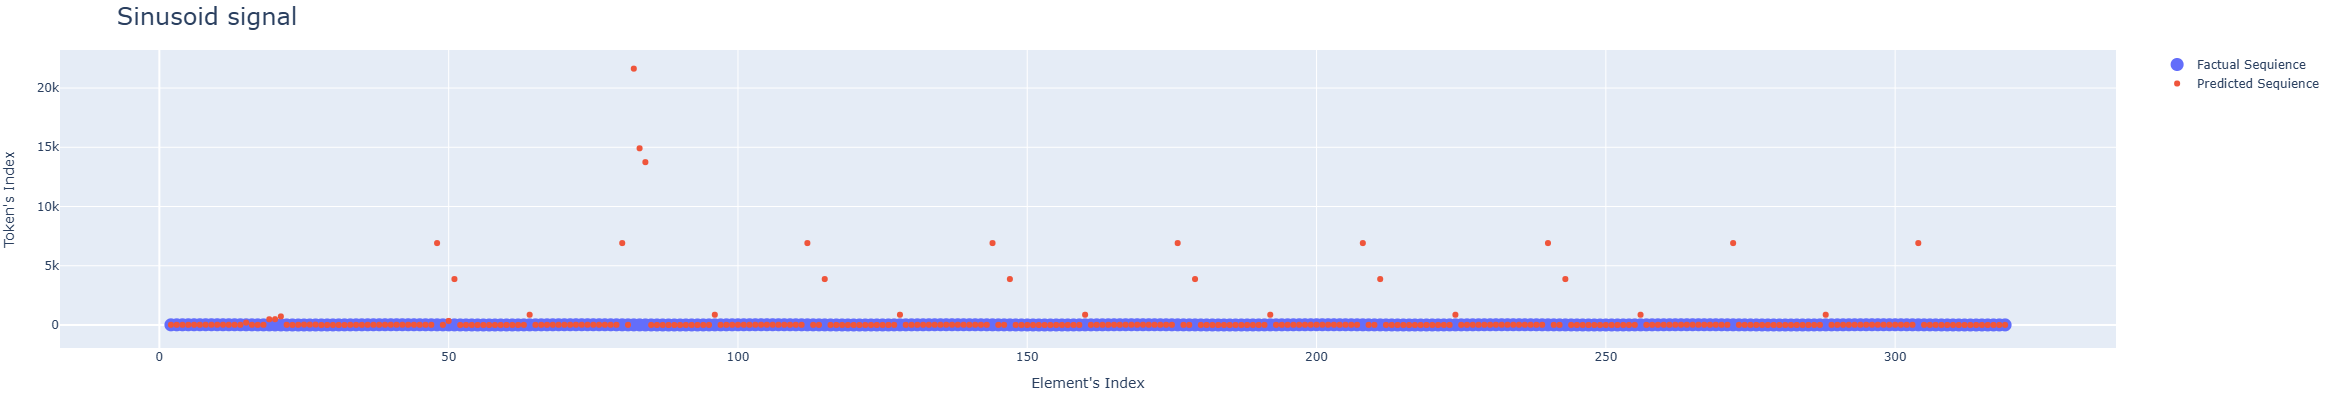

In [83]:
plot_sequence_prediction(factual_seq=sin_seq[1:], predicted_seq=sin1_predicts, start_from_idx=0, height=400, width=1600, plot_name="Sinusoid signal")

In [134]:
(sin1_predicts.numpy()[-256:] == sin_seq[-256:]).sum() / 256

0.90625

In [ ]:
sin1_predicts[]

In [64]:
sin_seq_200 = generate_pattern_sequence(pattern=(integer_sinusoid + 200).tolist(), seq_len=256, pattern_padding=2)

In [74]:
sin2_predicts, sin2_logits = run_sequence_through_model(model, torch.tensor(sin_seq_200, dtype=torch.int32).unsqueeze(0))

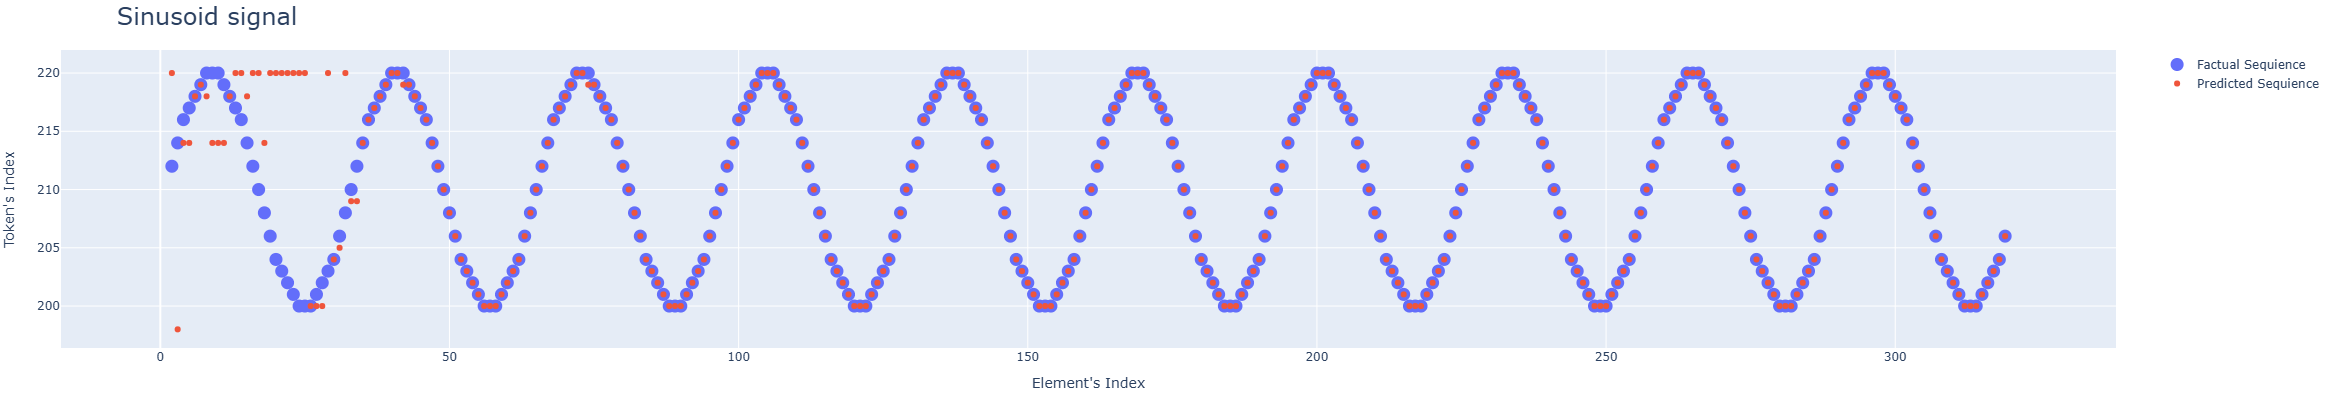

In [84]:
plot_sequence_prediction(factual_seq=sin_seq_200[1:], predicted_seq=sin2_predicts, start_from_idx=0, height=400, width=1600, plot_name="Sinusoid signal")

In [135]:
(sin2_predicts.numpy()[-256:] == sin_seq_200[-256:]).sum() / 256

0.99609375

In [68]:
sin_seq_2000 = generate_pattern_sequence(pattern=(integer_sinusoid + 2000).tolist(), seq_len=256, pattern_padding=2)

In [76]:
sin3_predicts, sin3_logits = run_sequence_through_model(model, torch.tensor(sin_seq_2000, dtype=torch.int32).unsqueeze(0))

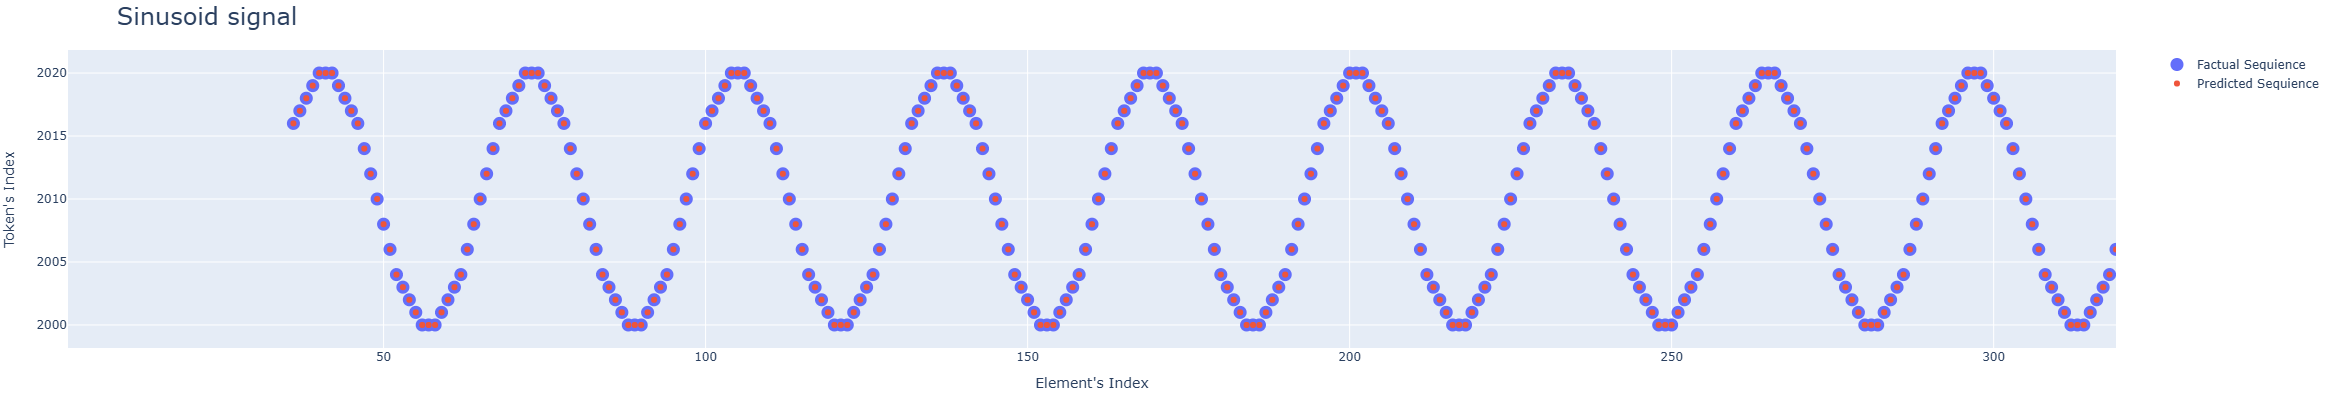

In [133]:
plot_sequence_prediction(factual_seq=sin_seq_2000[1:], predicted_seq=sin3_predicts, start_from_idx=34, height=400, width=1600, plot_name="Sinusoid signal")

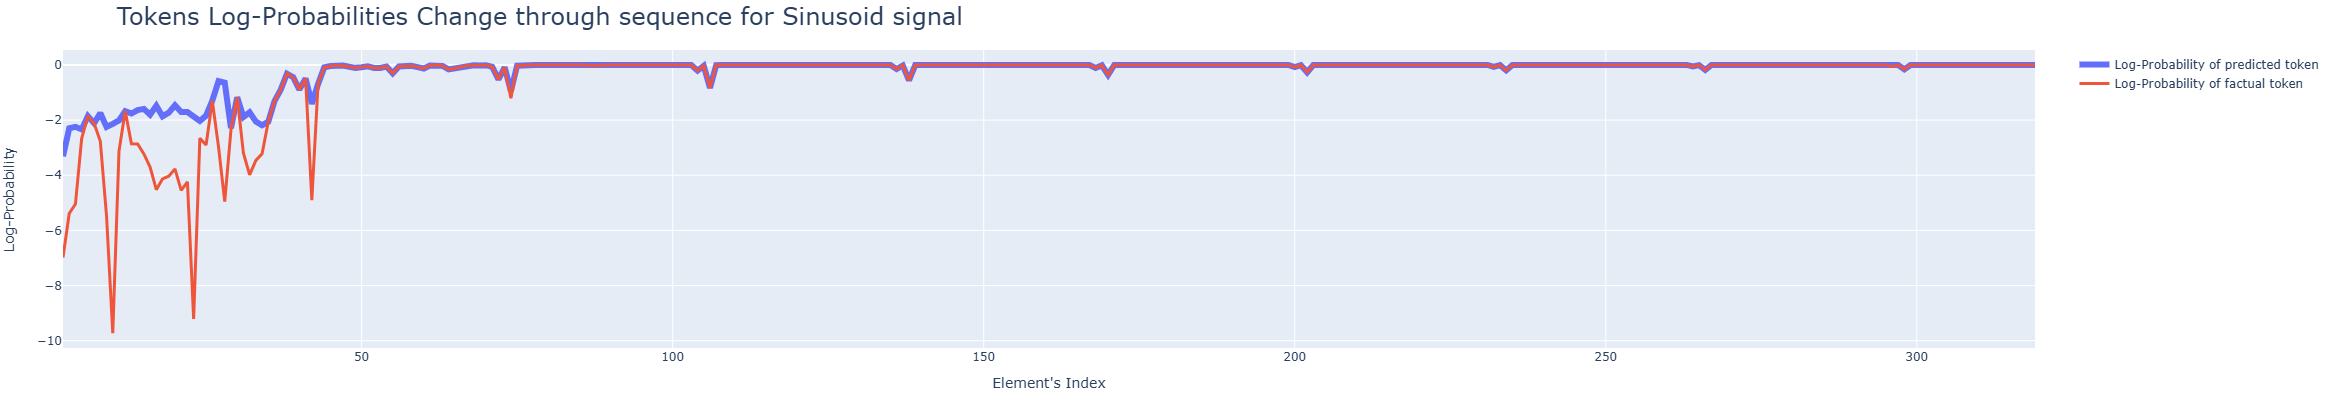

In [96]:
plot_log_prob(logits=sin2_logits, factual_seq=sin_seq_200, plot_name="Tokens Log-Probabilities Change through sequence for Sinusoid signal")

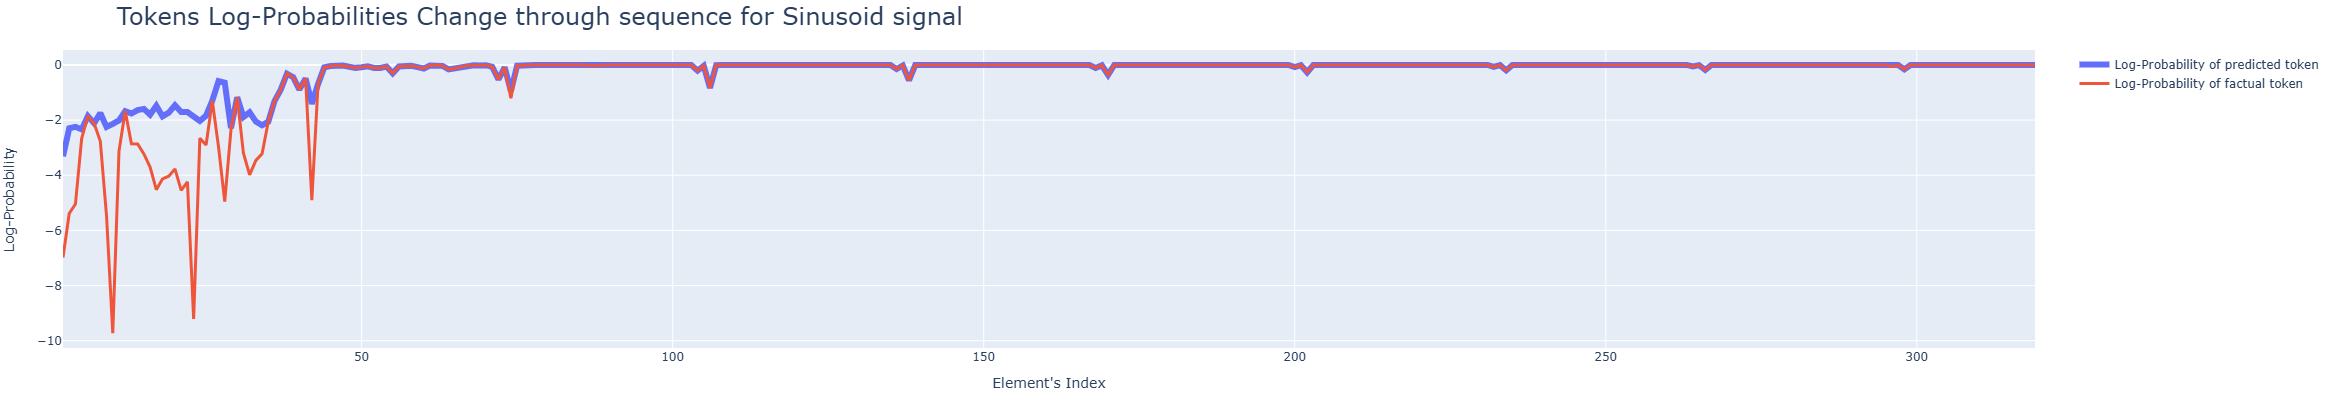

In [96]:
plot_log_prob(logits=sin2_logits, factual_seq=sin_seq_200, plot_name="Tokens Log-Probabilities Change through sequence for Sinusoid signal")

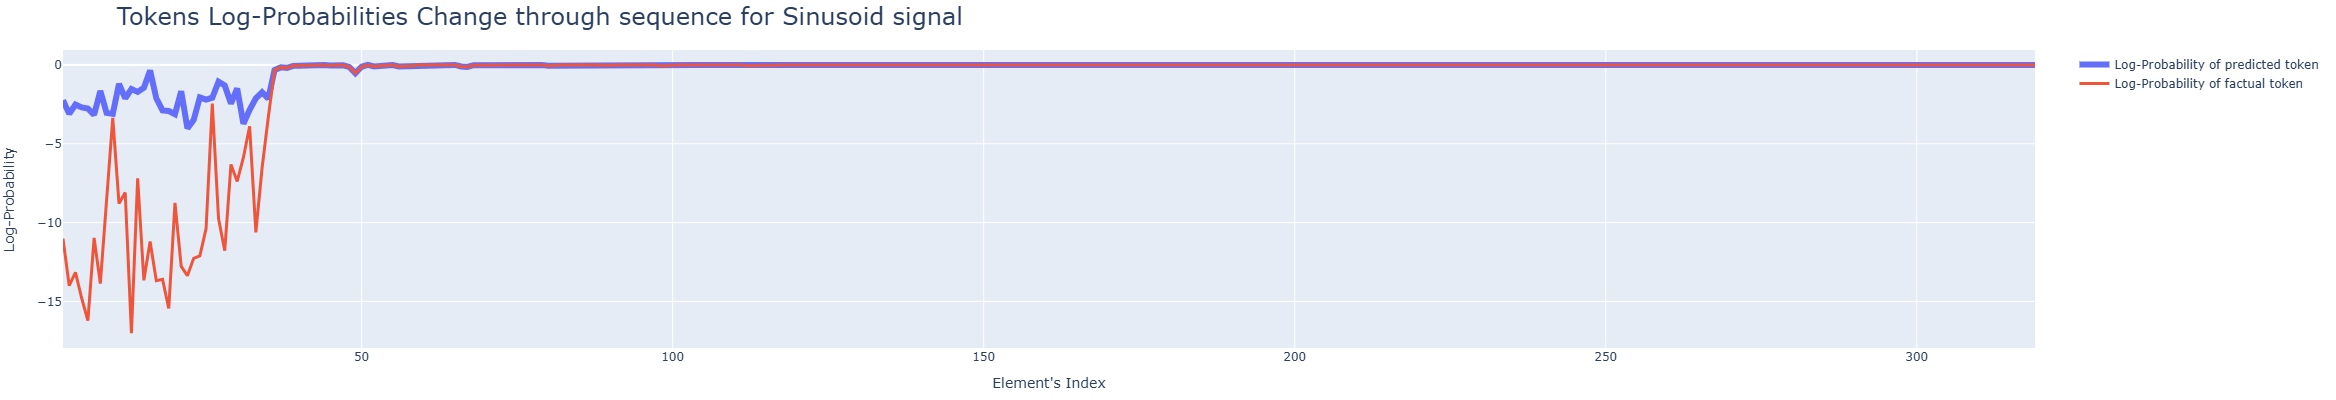

In [97]:
plot_log_prob(logits=sin3_logits, factual_seq=sin_seq_2000, plot_name="Tokens Log-Probabilities Change through sequence for Sinusoid signal")

In [36]:
sin_seq = generate_pattern_sequence(pattern=sinusoid_pattern, seq_len=256, pattern_padding=2)
sinusoid_result = test_sequence_shift(model, sequence=sin_seq, shifts=range(0, 100_000, 200), test_seq_len=256)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [59:22<00:00,  7.13s/it]


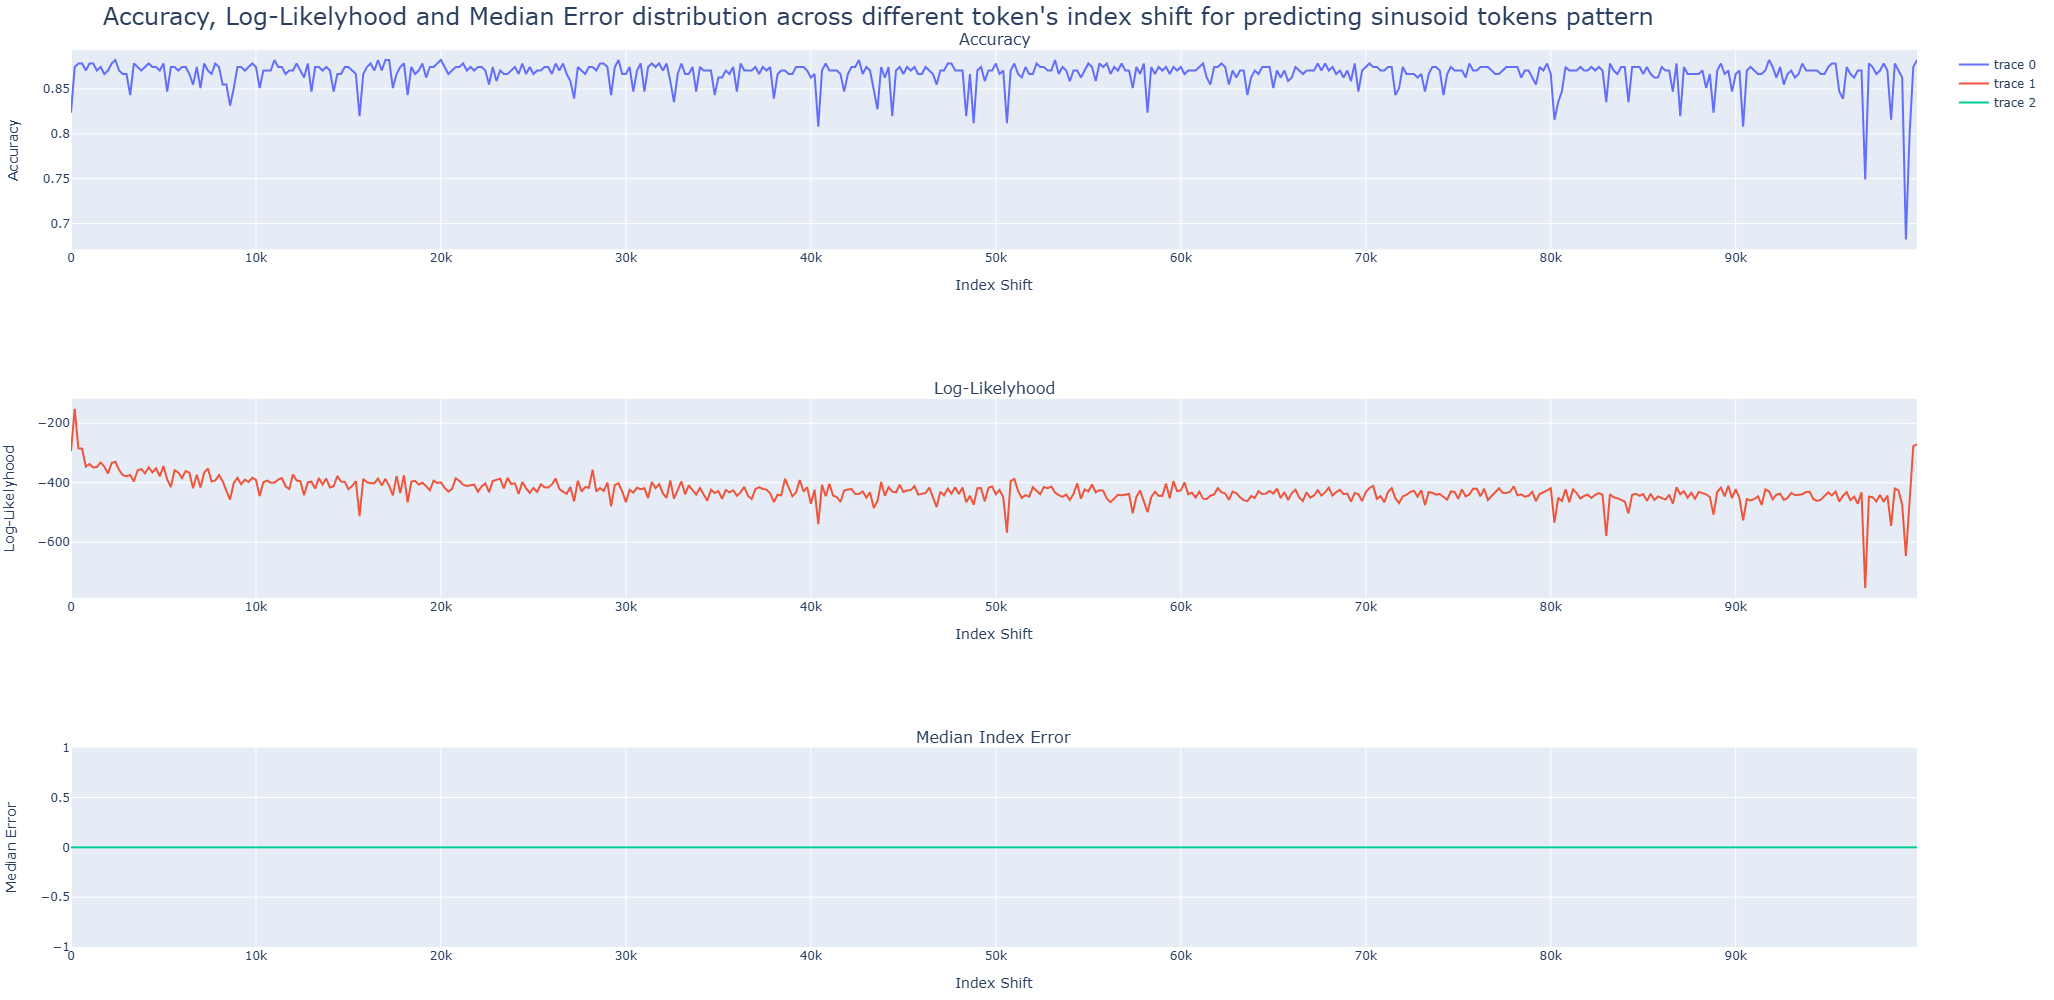

In [62]:
fig = make_subplots(rows=4, cols=1, subplot_titles=['Accuracy', 'Log-Likelyhood', 'Median Index Error', 'Start of matching'])

fig.add_trace(go.Scatter(x=np.array(range(0, 100_000, 200)), y=np.array([r[0] for r in sinusoid_result]), mode='lines'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.array(range(0, 100_000, 200)), y=np.array([r[1] for r in sinusoid_result]), mode='lines'), row=2, col=1)
fig.add_trace(go.Scatter(x=np.array(range(0, 100_000, 200)), y=np.array([r[2] for r in sinusoid_result]), mode='lines'), row=3, col=1)
fig.add_trace(go.Scatter(x=np.array(range(0, 100_000, 200)), y=np.array([r[3] for r in sinusoid_result]), mode='lines'), row=4, col=1)
# Update layout
fig.update_layout(title_text="Accuracy, Log-Likelyhood and Median Error distribution across different token's index shift for predicting sinusoid tokens pattern", height=1000, width=1800, title_font=dict(size=24), margin=dict(t=50, b=50, l=50, r=50))
fig.update_xaxes(title_text='Index Shift', row=1, col=1)
fig.update_xaxes(title_text='Index Shift', row=2, col=1)
fig.update_xaxes(title_text='Index Shift', row=3, col=1)
fig.update_xaxes(title_text='Index Shift', row=4, col=1)
fig.update_yaxes(title_text='Accuracy', row=1, col=1)
fig.update_yaxes(title_text='Log-Likelyhood', row=2, col=1)
fig.update_yaxes(title_text='Median Error', row=3, col=1)
fig.update_yaxes(title_text='Start of matching', row=4, col=1)
# Show the figure
fig.show()

In [29]:
def plot_series_in_df(df, name):
    fig = go.Figure()
    cols = df.columns
    for col in cols:
        fig.add_trace(go.Scatter(x=np.array(range(0, 100_000, 200)), y=df[col], mode='lines', name=col))
    fig.update_layout(title_text=name, height=500, width=1200, title_font=dict(size=24), margin=dict(t=50, b=50, l=50, r=50))
    fig.show()

In [37]:
global_result_dict = {}
key_map = {"acc": 0, "lkh": 1, "miderr": 2, "match": 3}

## Increasing diversity of tokens in pattern

In [39]:
np.array([2,3,4]).tolist()

[2, 3, 4]

In [ ]:
global_result_dict["id"] = {k: {} for k in key_map.keys()}
for i in range(2, 10, 2):
    temp_pattern = np.arange(0, i, 1, dtype=int).tolist()
    temp_seq = generate_pattern_sequence(pattern=temp_pattern, seq_len=256, pattern_padding=2)
    temp_result = test_sequence_shift(model, sequence=temp_seq, shifts=range(0, 100_000, 200), test_seq_len=256)
    for k, v in key_map.items():
        global_result_dict["id"][k][f"Num of tokens={i}"] = np.array([r[v] for r in temp_result])

  3%|██▊                                                                              | 17/500 [01:53<50:31,  6.28s/it]

## 'Signal after pause' experiment

testing capability of model to predict signal after pause, varying the pause length. By pause we understand  sequence of repeating 'neutral' token after which a 'signal' token folows. We will test, how models prediction capabilities varies with increasing pause length and signal deviation over tokens index shift.

### Varying Pause length

In [ ]:
global_result_dict["pl"] = {k: {} for k in key_map.keys()}
for i in range(1, 5):
    temp_pattern = [0] * int(2 ** i) + [1]
    temp_seq = generate_pattern_sequence(pattern=temp_pattern, seq_len=256, pattern_padding=2)
    temp_result = test_sequence_shift(model, sequence=temp_seq, shifts=range(0, 100_000, 200), test_seq_len=256)
    for k, v in key_map.items():
        global_result_dict["id"][k][f"Pause length={i}"] = np.array([r[v] for r in temp_result])

In [14]:
acc_pl_df = pd.DataFrame(acc_dict_pl)
lkh_pl_df = pd.DataFrame(lkh_dict_pl)
miderr_pl_df = pd.DataFrame(miderr_dict_pl)

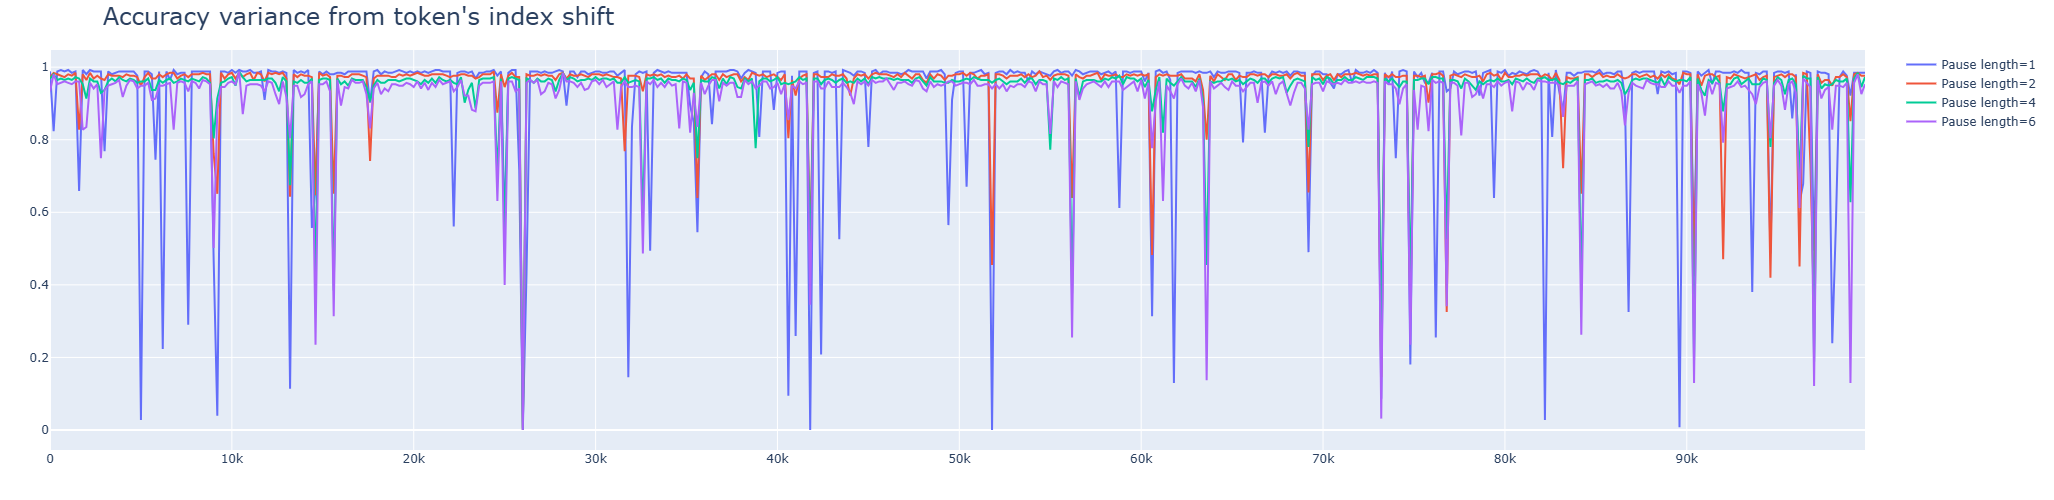

In [27]:
plot_series_in_df(acc_pl_df, "Accuracy variance from token's index shift")

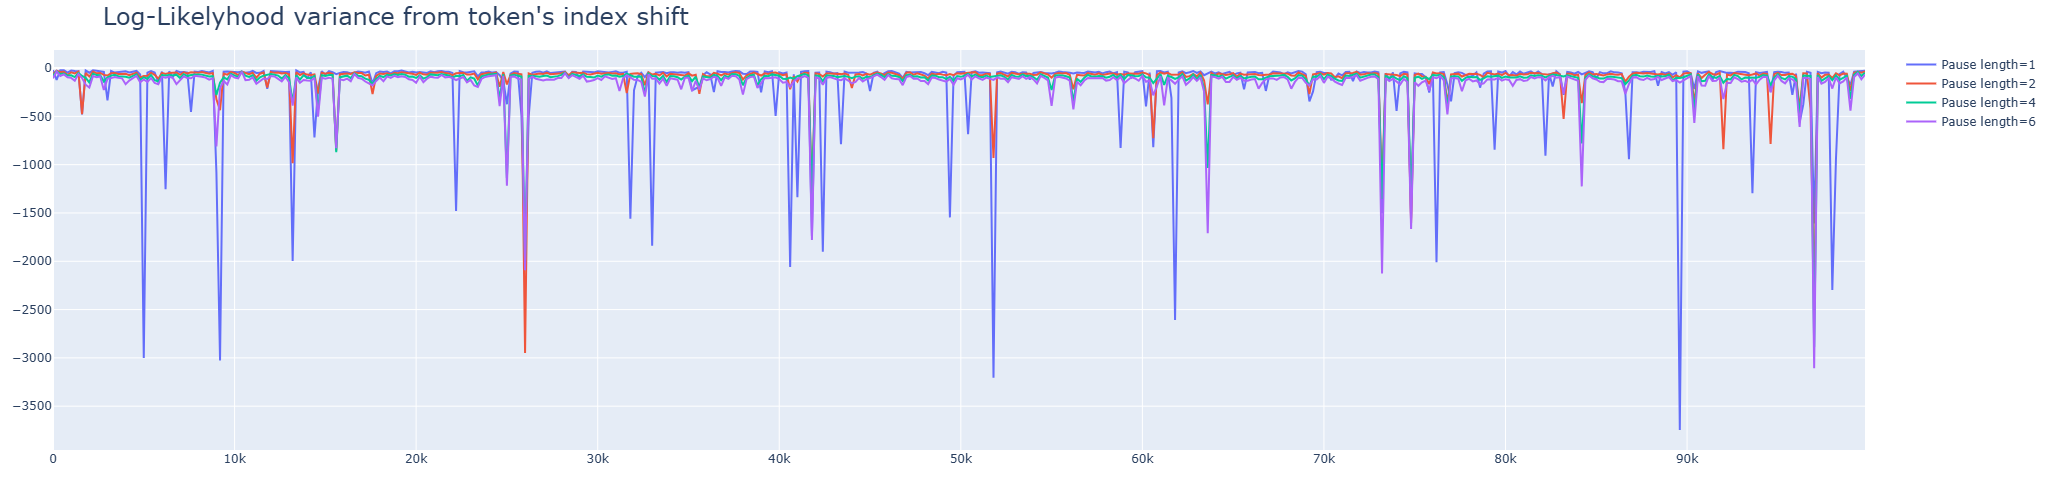

In [30]:
plot_series_in_df(lkh_pl_df, "Log-Likelyhood variance from token's index shift")

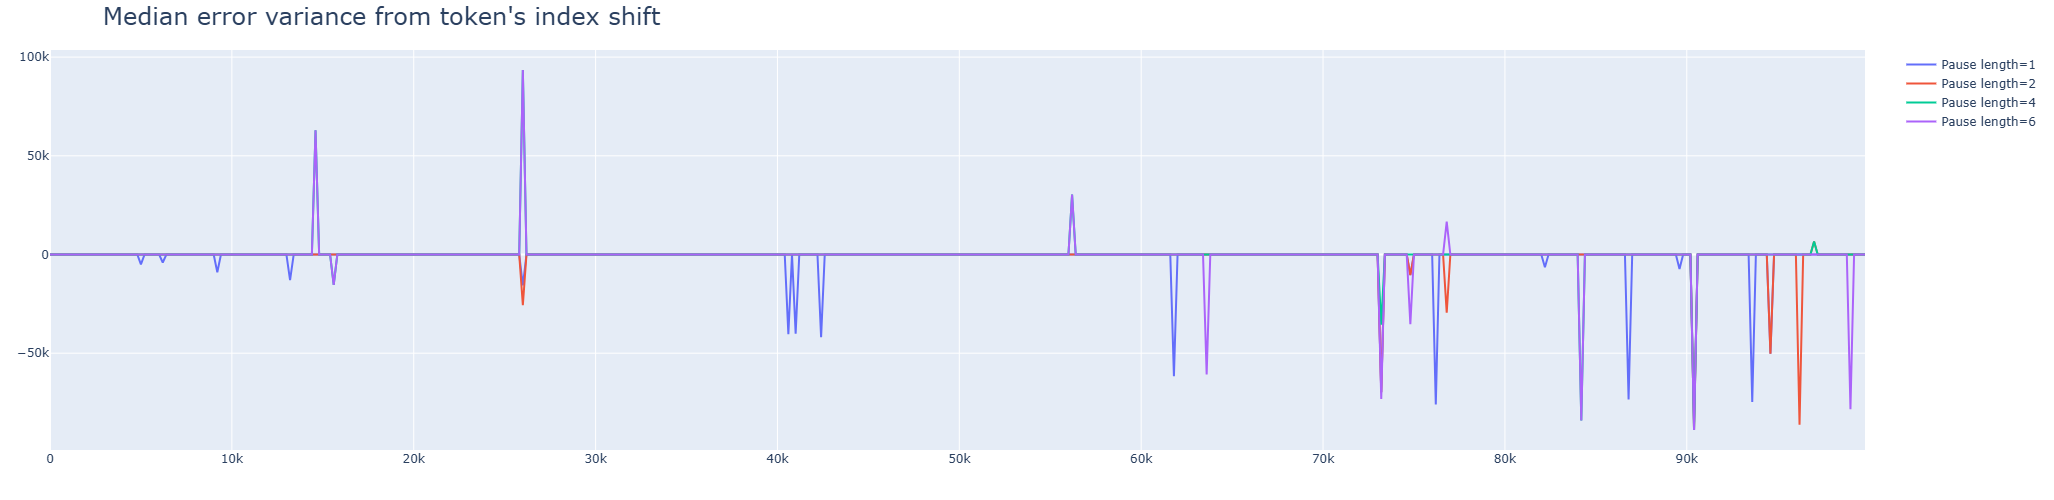

In [32]:
plot_series_in_df(miderr_pl_df, "Median error variance from token's index shift")

# Functional Approximation

In [ ]:
def encode_num_seq(num_seq: list, encode_token: int, separator: int):
    result_seq = []
    for n in num_seq:
        result_seq += [encode_token] * int(n) + [separator]
    return result_seq

In [ ]:
def decode_tokens_seq(tokens_seq, encode_token: int, separator: int, start_from: int = 0):
    encode_tokens = np.unique([encode_token, separator])
    for num_seq_start in range(start_from, len(tokens_seq)):
        if np.array_equal(np.unique(tokens_seq[num_seq_start:]), encode_tokens):
            break
            
    if num_seq_start == len(tokens_seq) - 1:
        return []
    
    num_seq = tokens_seq[num_seq_start:]
    
    result_seq = []
    curr_n = 0
    for t in num_seq:
        if t == encode_token:
            curr_n += 1
        else:
            result_seq.append(curr_n)
            curr_n = 0
    return result_seq

## Linear growth

In [ ]:
lin_seq = encode_num_seq(num_seq=np.arange(1, 11), encode_token=0, separator=1)
linear_result = test_sequence_shift(model, sequence=lin_seq, shifts=range(0, 100_000, 200), test_seq_len=len(lin_seq))

## Quadratic growth

In [ ]:
quad_seq = encode_num_seq(num_seq=np.arange(1, 11) ** 2, encode_token=0, separator=1)
quad_result = test_sequence_shift(model, sequence=lin_seq, shifts=range(0, 100_000, 200), test_seq_len=len(quad_seq))

In [26]:
np.array_equal(np.unique([0,0,1,0,1,0,1]), np.unique([0, 1]))

True

# Working with noise sequence

In [125]:
def plot_log_prob_with_noise(logits, base_seq, noise_indecies, plot_name, height=400, width=1200):
    fig = go.Figure()
    x = np.arange(2, logits.shape[0] + 1)
    log_probs = F.log_softmax(logits, dim=-1)
    base_log_probs = log_probs[torch.arange(logits.shape[0]), base_seq[1:]].numpy()
    predicted_log_probs = log_probs.numpy().max(axis=1)
    fig.add_trace(go.Scatter(x=x, y=predicted_log_probs, mode='lines', line={'width': 6}, name="Log-Probability of predicted token"))
    fig.add_trace(go.Scatter(x=x, y=base_log_probs, mode='lines', line={'width': 3}, name="Log-Probability of baseline token"))
    for idx in noise_indecies:
        fig.add_vline(x=idx, line_width=1, line_dash="dash", line_color="black")
    fig.update_layout(title_text=plot_name, title_font=dict(size=24), height=height, width=width, margin=dict(t=50, b=50, l=50, r=50))
    fig.update_xaxes(title_text="Element's Index", range=[1, len(base_seq)])
    fig.update_yaxes(title_text="Log-Probability")
    fig.show()

## Sinusoid with noise

In [112]:
sin_seq_orig = generate_pattern_sequence(pattern=sinusoid_pattern, seq_len=256, pattern_padding=2) + 200
sin_seq_noised = sin_seq_orig.copy()
np.random.seed(42)
noise_idxs = []
for i in range(-256, 0):
    if np.random.rand() <= 0.1:
        noise_idxs.append(len(sin_seq_orig) + i)
        sin_seq_noised[i] += np.random.randint(0, 201) - 100

In [107]:
sin_noiz_predicts, sin_noiz_logits = run_sequence_through_model(model, torch.tensor(sin_seq_noised, dtype=torch.int32).unsqueeze(0))

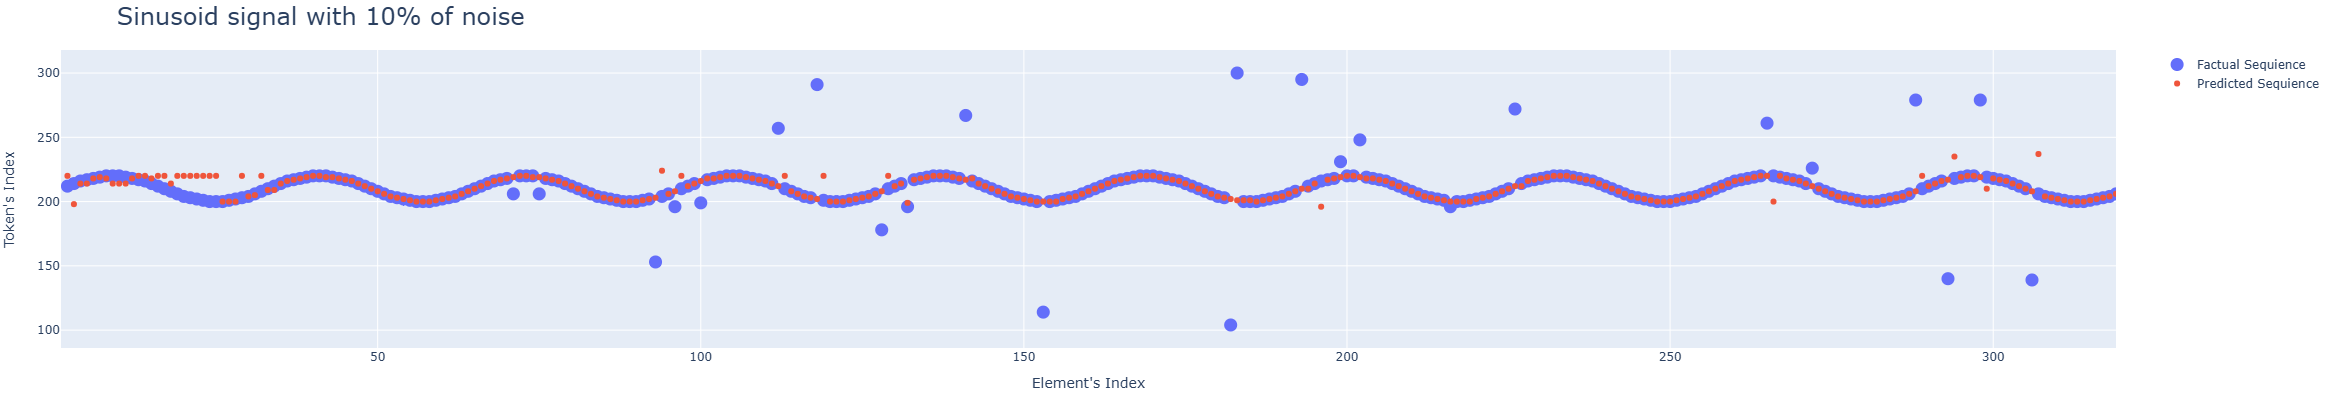

In [117]:
plot_sequence_prediction(factual_seq=sin_seq_noised[1:], predicted_seq=sin_noiz_predicts, start_from_idx=0, height=400, width=1600, plot_name="Sinusoid signal with 10% of noise")

In [109]:
(sin_noiz_predicts.numpy()[-256:] == sin_seq_orig[-256:]).sum() / 256

0.90234375

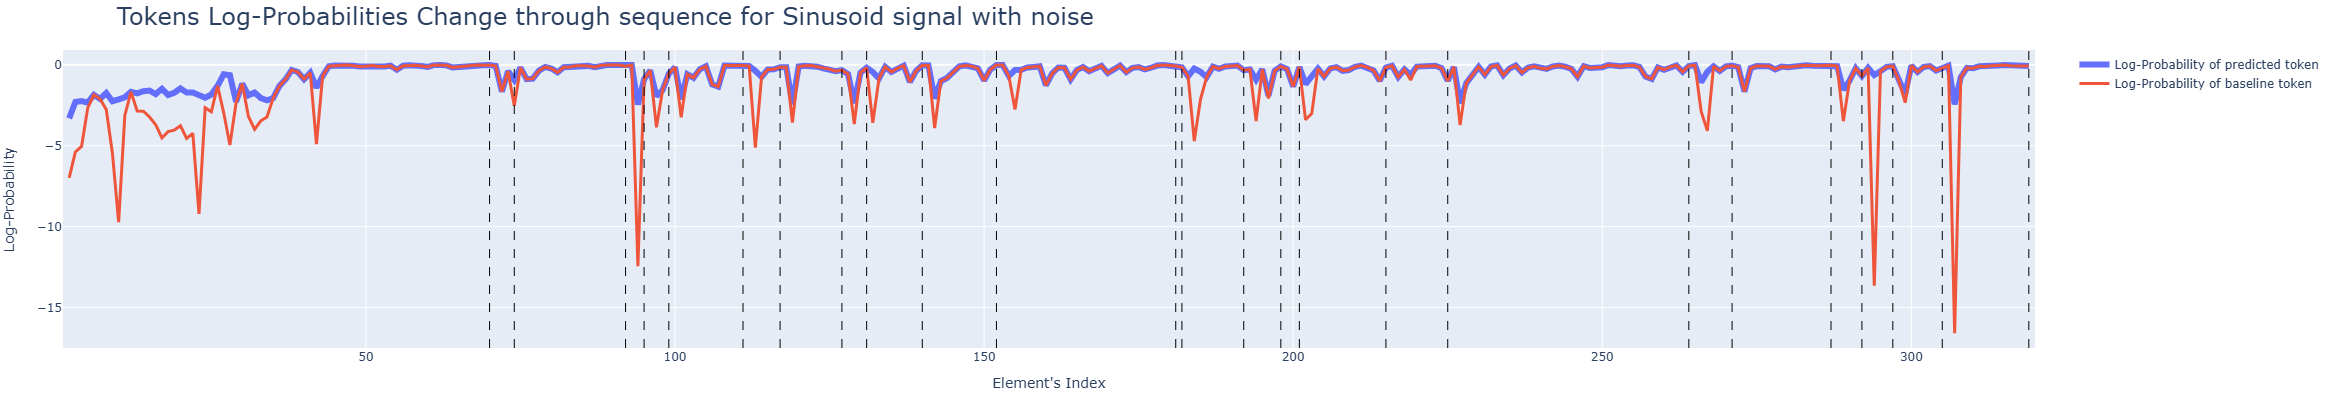

In [126]:
plot_log_prob_with_noise(logits=sin_noiz_logits, base_seq=sin_seq_orig, noise_indecies=noise_idxs, plot_name="Tokens Log-Probabilities Change through sequence for Sinusoid signal with noise", height=400, width=1700)

In [127]:
sin_seq_orig = generate_pattern_sequence(pattern=sinusoid_pattern, seq_len=256, pattern_padding=2) + 2000
sin_seq_noised = sin_seq_orig.copy()
np.random.seed(42)
noise_idxs = []
for i in range(-256, 0):
    if np.random.rand() <= 0.1:
        noise_idxs.append(len(sin_seq_orig) + i)
        sin_seq_noised[i] += np.random.randint(0, 201) - 100

In [128]:
sin_noiz_predicts, sin_noiz_logits = run_sequence_through_model(model, torch.tensor(sin_seq_noised, dtype=torch.int32).unsqueeze(0))

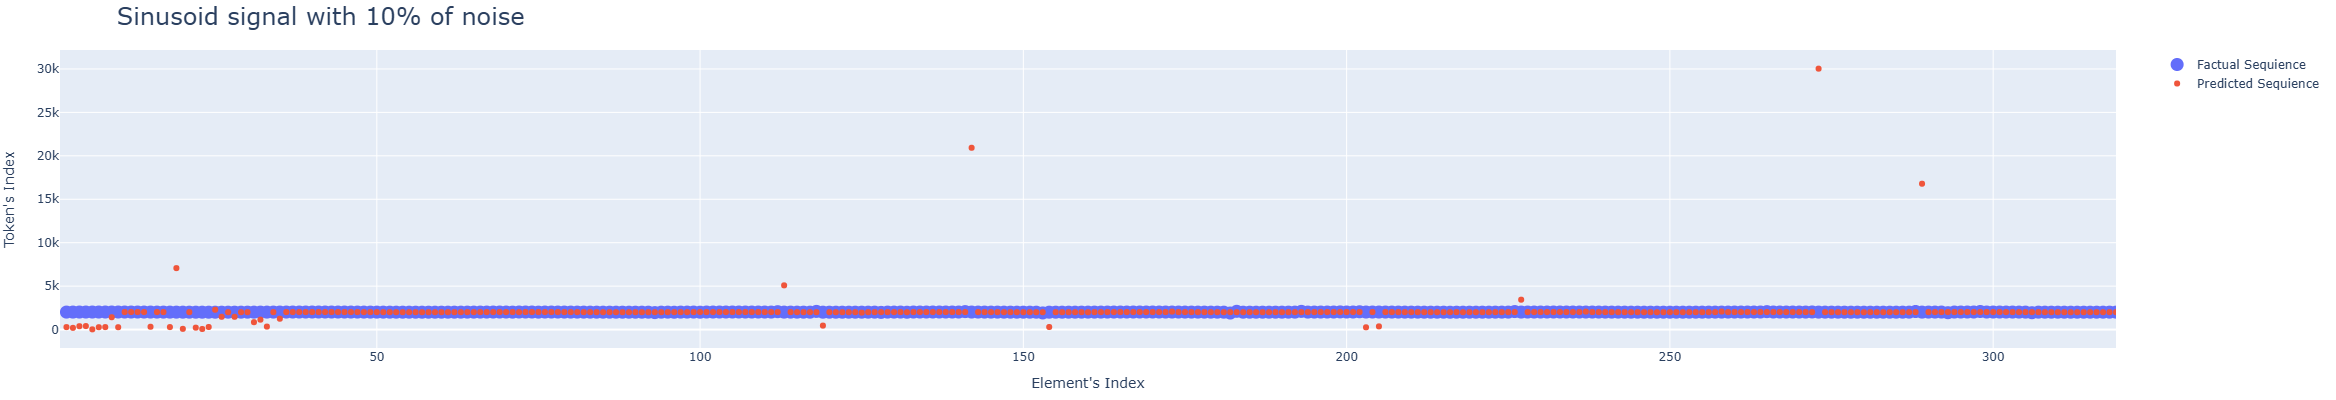

In [129]:
plot_sequence_prediction(factual_seq=sin_seq_noised[1:], predicted_seq=sin_noiz_predicts, start_from_idx=0, height=400, width=1600, plot_name="Sinusoid signal with 10% of noise")

In [130]:
(sin_noiz_predicts.numpy()[-256:] == sin_seq_orig[-256:]).sum() / 256

0.83984375

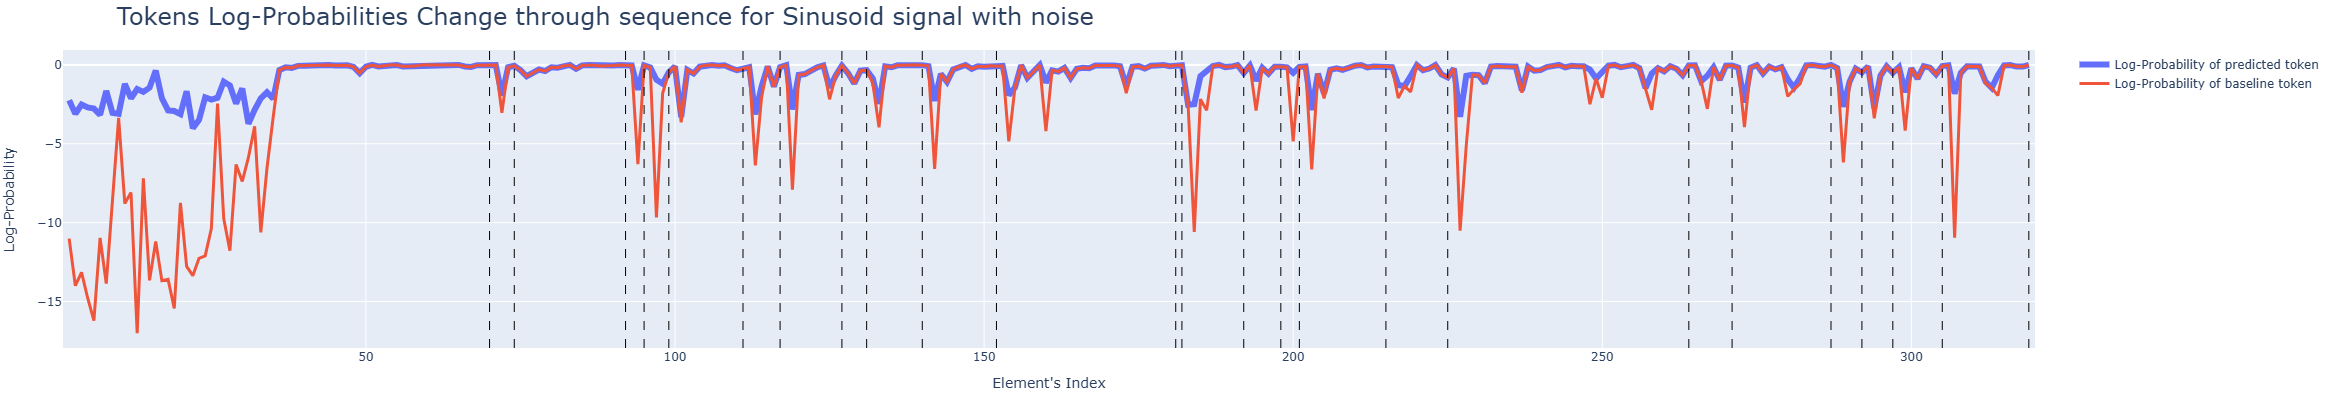

In [131]:
plot_log_prob_with_noise(logits=sin_noiz_logits, base_seq=sin_seq_orig, noise_indecies=noise_idxs, plot_name="Tokens Log-Probabilities Change through sequence for Sinusoid signal with noise", height=400, width=1700)

## Approximate functional operator 

Subtraction operator: Sequence of token A length N| Sequence of token B length M| Operator's Token => Sequence of A N - M if it's sequence is bigger else B length M - N 